In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import datetime as dt
from pathlib import Path
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session,declarative_base
from sqlalchemy import create_engine, func, text,Column, Integer, String,Date, Float,inspect,and_

style.use('fivethirtyeight')

# Reflect Tables into SQLAlchemy ORM

In [2]:
#class
class measurement_tb(declarative_base()):
    __tablename__="measurement"
    station=Column(String,primary_key=True)
    date=Column(Date)
    precipitation=Column(Float)
    temperature=Column(Float)

In [3]:
#Declare dependancies
database_path= Path("../Resources/hawaii.sqlite")
#Create engine to sqlite
engine=create_engine(f"sqlite:///{database_path}")

In [4]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [5]:
#Get columns details for all tables
for table in inspector.get_table_names():
    print('----')
    print("Table name: " + table)
    print('----')
    columns_details=inspector.get_columns(table)
    for column in columns_details:
        print(column['name'],column['type'])

----
Table name: measurement
----
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----
Table name: station
----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the station class to a variable called `station`
Station=Base.classes.station
# Assign the measurement class to a variable called `measurement`
Measurement=Base.classes.measurement

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_record = session.query(Measurement).order_by(Measurement.date.desc()).first()
most_recent_record.date

'2017-08-23'

In [10]:
#Convert most recent record.date to date time
most_recent_record_converted=dt.datetime.strptime(most_recent_record.date,'%Y-%m-%d')
# Calculate the date 12 months ago from the most recent date in the dataset
twelve_months_ago = most_recent_record_converted-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precipitation_result=session.query(Measurement.date,Measurement.prcp).filter(
    Measurement.date>=twelve_months_ago).all()
#Save the query results as a Pandas DataFrame.
precipitation_df=pd.DataFrame(precipitation_result,columns=\
                              ['Date',"Precipitation"]).sort_values(by='Date',ascending=False)
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date']).dt.date
precipitation_df


,Date,Precipitation
2222,2017-08-23,11.4
1523,2017-08-23,2.0
1005,2017-08-23,0.0
359,2017-08-23,0.0
1522,2017-08-22,0.0
...,...,...
1188,2016-08-24,31.0
1875,2016-08-24,36.8
360,2016-08-24,54.6
1524,2016-08-24,54.6


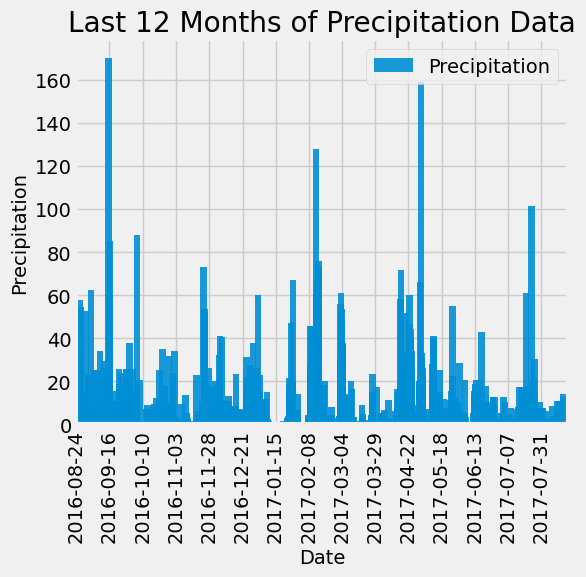

In [11]:
#Plot a bar chart
plt.figure(figsize=(6, 6))
precipitation_df.sort_values(by='Date').set_index('Date')['Precipitation'].plot(kind='bar',\
                                                                                width=30, alpha=0.9,position=0,\
                                                                               legend=True,grid=True)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Last 12 Months of Precipitation Data')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_station=session.query(Station.station)
total_station.count()

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations=session.query(Measurement.station,func.count(Measurement.station)).\
                                    group_by(Measurement.station).\
                                    order_by(func.count(Measurement.station).desc())
#Show the top 10 active stations
most_active_stations.limit(10).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station=session.query(Measurement.station,func.min(Measurement.tobs),\
                                 func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                                    group_by(Measurement.station).\
                                    order_by(func.count(Measurement.station).desc()).first()
most_active_station

('USC00519281', 12.2, 29.4, 22.03582251082252)

In [16]:
# Using the most active station id
#Get the recent date of the most active station
most_recent_date_most_active_station=session.query(Measurement.date).filter(Measurement.station==most_active_station[0]).\
                                            order_by(Measurement.date.desc()).first()[0]

#Convert most recent record.date to date time
most_recent_date_most_active_station_converted=dt.datetime.strptime(most_recent_date_most_active_station,'%Y-%m-%d')
# Calculate the date 12 months ago from the most recent date in the dataset
twelve_months_ago = most_recent_date_most_active_station_converted-dt.timedelta(days=365)
# Query the last 12 months of temperature observation data for this station
temperate_most_active_station_last12months=session.query(Measurement.tobs).\
                                            filter(and_(Measurement.date>=twelve_months_ago,\
                                                       Measurement.station==most_active_station[0])).all()
#Save the query results as a Pandas DataFrame.
temperate_most_active_station_last12months_df=pd.DataFrame(temperate_most_active_station_last12months,\
                                                          columns=['Temperature'])

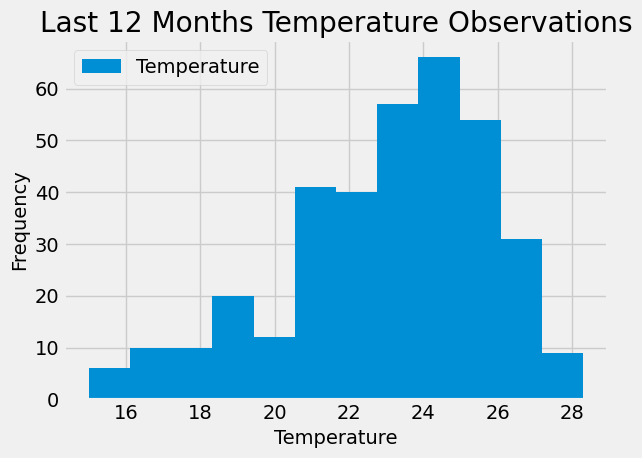

In [17]:
#Plot the results as a histogram
temperate_most_active_station_last12months_df.plot(kind='hist',\
                                                        bins=12,alpha=1,\
                                                        legend=True)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Last 12 Months Temperature Observations')
plt.tight_layout()

plt.show()

# Close Session

In [18]:
# Close Session
session.close()